In [1]:
import numpy as np
import pandas as pd
df = pd.read_csv('tests_perfomance/datasets/wine.csv')

In [2]:
df.quality.value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [15]:
from pandas.api.types import CategoricalDtype
target =  df.quality
categ = [3, 4, 5, 6, 7, 8]
cat_type = CategoricalDtype(categories=categ, ordered=True)
target = target.astype(cat_type)
X = df.iloc[:, :-1]
from sklearn.model_selection import cross_val_score

In [5]:
from sklearn.linear_model import LogisticRegression

In [203]:
from functools import reduce
import warnings
import sklearn.exceptions
from sklearn.exceptions import ConvergenceWarning
prod = lambda x, y: x * y

class SequentialOrdinalRegressor:
    def __init__(self, base_model, base_model_params=None, random_state=None, suppress_warnings=True):
        self.random_state = random_state
        self.base_model = base_model
        self.base_model_params = base_model_params
        self.models = None
        self.suppress_warnings = suppress_warnings
    
    def fit(self, X, y):
        if self.random_state is not None:
            np.random.seed(self.random_state)
        
        self.models = []
        self.categories = y.cat.categories
        for i, cat in enumerate(self.categories[:-1]):
            labels = [0] * len(self.categories[:i+1]) + [1] * len(self.categories[i + 1:])
            map = {cat: labels[j] for j, cat in enumerate(self.categories)}
            y_enc = y.replace(map)
            if self.suppress_warnings:
                with warnings.catch_warnings():
                    warnings.filterwarnings("ignore", category=ConvergenceWarning)
                    mod = self.base_model(**self.base_model_params)
                    mod.fit(X, y_enc)
                    self.models.append(mod)
            else:
                mod = self.base_model(**self.base_model_params)
                mod.fit(X, y_enc)
                self.models.append(mod)
        return self
    
    def predict(self, X):
        pred = []
        for i, x in X.iterrows():
            binary_probabilities = [mod.predict_proba(x.values.reshape(1, -1)) for mod in self.models]
            neg_probs = [p[0][0] for p in binary_probabilities]
            pos_probs = [p[0][1] for p in binary_probabilities]
            bin_probabilities = []
            for i in range(len(self.models)):
                bin_prob = [p for p in pos_probs[:i]] + [neg_probs[i]]
                reduced = reduce(prod, bin_prob)
                bin_probabilities.append(reduced)
            bin_probabilities.append(reduce(prod, pos_probs))
            pred.append(self.categories[np.argmax(bin_probabilities)])
        return np.array(pred)
    
    def predict_proba(self, X):
        probs = []
        for x in X:
            binary_probabilities = [mod.predict_proba(x.reshape(1, -1)) for mod in self.models]
            neg_probs = [p[0][0] for p in binary_probabilities]
            pos_probs = [p[0][1] for p in binary_probabilities]
            bin_probabilities = []
            for i in range(len(self.models)):
                bin_prob = [p for p in pos_probs[:i]] + [neg_probs[i]]
                reduced = reduce(prod, bin_prob)
                bin_probabilities.append(reduced)
            bin_probabilities.append(reduce(prod, pos_probs))
            probs.append(bin_probabilities)
        return np.array(probs)
    
    def get_params(self, *args, **kwargs):
        return dict(base_model=self.base_model, base_model_params=self.base_model_params)
    
    def __repr__(self):
        return f"Sequential Ordinal Regressor | base={repr(self.base_model)}"

In [204]:
m = SequentialOrdinalRegressor(LogisticRegression, dict(random_state=42, solver='lbfgs', class_weight='balanced'), random_state=42)

In [205]:
m.fit(X, target)

Sequential Ordinal Regressor | base=<class 'sklearn.linear_model.logistic.LogisticRegression'>

In [216]:
cross_val_score(m, X, target, cv=5, scoring='balanced_accuracy').mean()

/home/ptyshevskyi/envs/loc_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1745: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/ptyshevskyi/envs/loc_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1745: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


0.330323742141874

In [215]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    print(cross_val_score(LogisticRegression(solver='lbfgs', random_state=42, multi_class='auto'), X, y=target, cv=5, scoring='balanced_accuracy').mean())

0.23403498314780086


In [94]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
cross_val_score(rf_classifier, X, target, cv=5).mean()

0.5679802397137192

In [107]:
def my_cv_score(model, scoring, X, y, cv=3, verbose=False):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    batch_size = len(indices) // cv
    cv_scores = []
    for i in range(cv):
        idx_train = np.concatenate([indices[:batch_size * i], indices[batch_size * (i + 1):]])
        idx_test = indices[batch_size * i: batch_size * (i + 1)]
        X_train, y_train = X.iloc[idx_train, :], y[idx_train]
        X_test, y_test = X.iloc[idx_test, :], y[idx_test]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = scoring(y_test, y_pred)
        if verbose:
            print(f"[{i}]: {score}")
        cv_scores.append(score)
    return np.array(cv_scores)

In [108]:
from sklearn.metrics import accuracy_score
m = SequentialOrdinalRegressor(LogisticRegression, dict(random_state=42, solver='lbfgs'), random_state=42)
cv_scores = my_cv_score(m, accuracy_score, X, target, cv=5)

In [110]:
cv_scores.mean()

0.5968652037617554

In [111]:
reg_model = LogisticRegression(multi_class='auto', solver='lbfgs', random_state=42)
my_cv_score(reg_model, accuracy_score, X, target, cv=5).mean()

/home/ptyshevskyi/envs/loc_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/ptyshevskyi/envs/loc_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/ptyshevskyi/envs/loc_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/ptyshevskyi/envs/loc_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/ptyshevskyi/envs/loc_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs faile

0.5774294670846395

In [112]:
m2 = SequentialOrdinalRegressor(RandomForestClassifier, dict(random_state=42, n_estimators=100), random_state=42)
my_cv_score(m2, accuracy_score, X, target, cv=5, verbose=True).mean()

0.6921630094043887

In [113]:
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
my_cv_score(rf_model, accuracy_score, X, target, cv=5, verbose=True).mean()

0.7040752351097179

In [180]:
import matplotlib.pyplot as plt

def compare_distributions(model1, model2, sample):
    f, ax = plt.subplots(ncols=2, figsize=(16, 8))

    ax[0].bar(target.cat.categories, model1.predict_proba(sample)[0]);
    ax[0].set_title(f"{repr(model1)[:50]} probability distribution");

    ax[1].bar(target.cat.categories, model2.predict_proba(sample)[0]);
    ax[1].set_title(f"{repr(model2)[:50]} probability distribution");

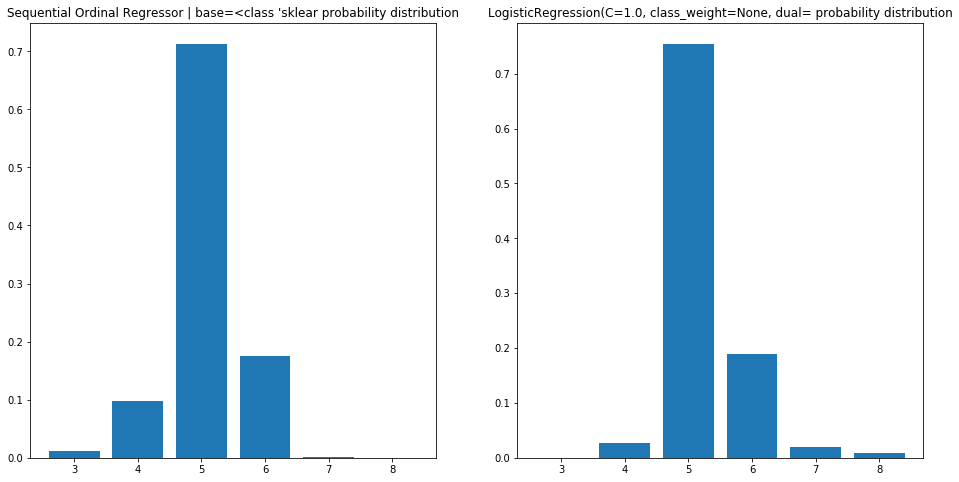

In [181]:
compare_distributions(m, reg_model, X.iloc[0,:].values.reshape(1, -1))

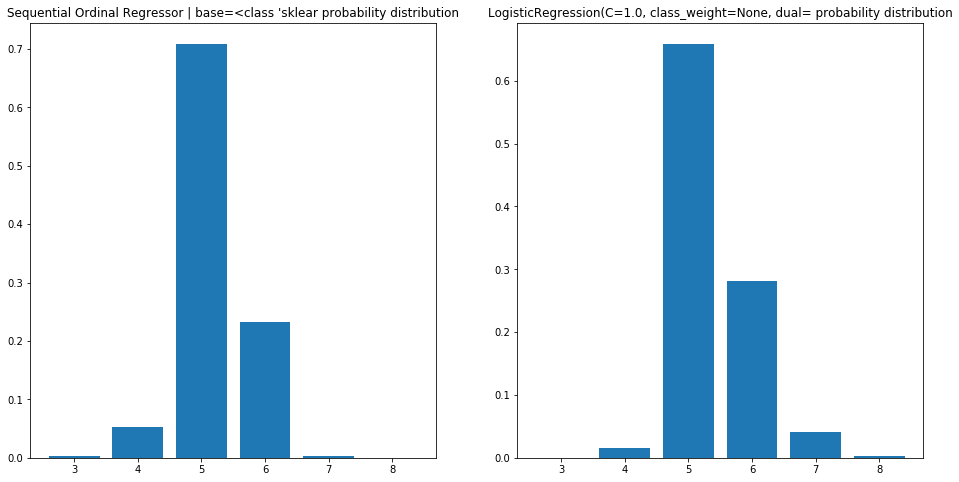

In [182]:
compare_distributions(m, reg_model, X.iloc[1,:].values.reshape(1, -1))

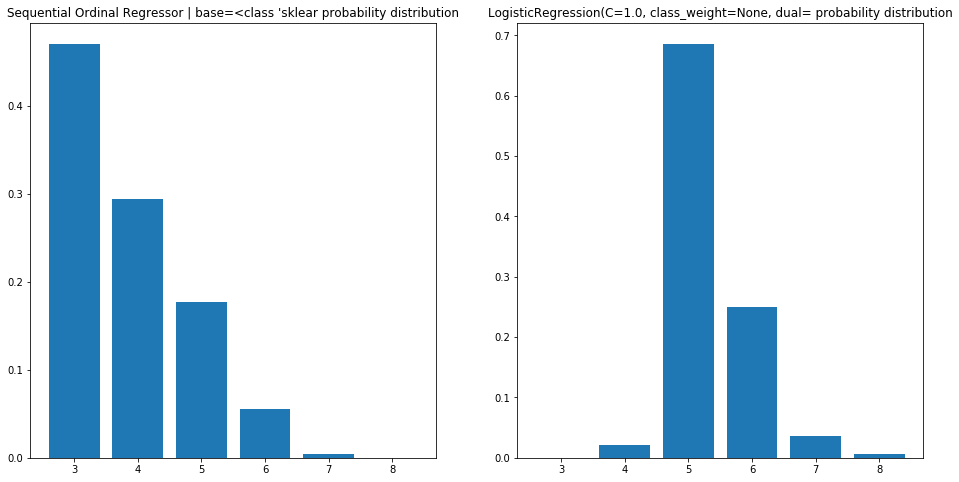

In [220]:
compare_distributions(m, reg_model, X.iloc[99,:].values.reshape(1, -1))